## Visualize decoding results
* This is the front-end for **decoder_cli_paper.py** 
* Run decoder_cli_paper.py to generate results for each of 12 patients. (Run using BASH example provided in decoder_cli_paper.py's header)
* decoder_cli_paper.py generates files in **reports/**, which this notebooks reads from


In [1]:
from IPython.core.display import HTML

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'
# mpl.rcParams['figure.dpi'] = 600
import pandas as pd
from scipy import signal
import numpy as np; np.random.seed(1337)
import scipy as sp
import sys, os
import tqdm
import glob
import pickle

from scipy import stats
import paper_utils as paperu

In [2]:
import config_paper as config

hemispheres = config.constants['HEMISPHERES']
patient_ids = config.constants['PATIENT_IDS_PAPER']
print('patient_ids', patient_ids)
decoder_days = config.constants['ECOG_DAYS_PAPER']
DATA_DIR = config.constants['DATA_DIR']
LIMBS = ['r_wrist', 'l_wrist']

REPORT_DIR = 'reports/' # output of decoder_cli_paper.py
print(REPORT_DIR)

patient_ids ['a0f66459', 'c95c1e82', 'cb46fd46', 'fcb01f7a', 'ffb52f92', 'b4ac1726', 'f3b79359', 'ec761078', 'f0bbc9a9', 'abdb496b', 'ec168864', 'b45e3f7b']
reports/


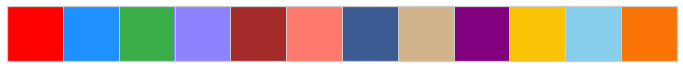

In [3]:
# Common https://xkcd.com/color/rgb/
pal_name = [
    'red',
    'dodgerblue',
    sns.xkcd_rgb["medium green"],
    sns.xkcd_rgb["periwinkle"],
    'brown',
    sns.xkcd_rgb["salmon"],
    sns.xkcd_rgb["denim blue"],
    'tan', 
    'purple', 
    sns.xkcd_rgb["goldenrod"],
    'skyblue', 
    sns.xkcd_rgb["orange"],
   ][:len(patient_ids)]
sns.set_palette(pal_name)
sns.palplot(sns.color_palette(pal_name, len(pal_name)))

## Load all reports

In [4]:
report_files = glob.glob(REPORT_DIR + "*.csv")
sorted(report_files)
# assert len(report_files) == 24 # Reports exist for 12 patients x 2 limbs

['reports/a0f66459_l_wrist_identity_classify.csv',
 'reports/a0f66459_r_wrist_identity_classify.csv',
 'reports/abdb496b_l_wrist_identity_classify.csv',
 'reports/abdb496b_r_wrist_identity_classify.csv',
 'reports/b45e3f7b_l_wrist_identity_classify.csv',
 'reports/b45e3f7b_r_wrist_identity_classify.csv',
 'reports/b4ac1726_l_wrist_identity_classify.csv',
 'reports/b4ac1726_r_wrist_identity_classify.csv',
 'reports/c95c1e82_l_wrist_identity_classify.csv',
 'reports/c95c1e82_r_wrist_identity_classify.csv',
 'reports/cb46fd46_l_wrist_identity_classify.csv',
 'reports/cb46fd46_r_wrist_identity_classify.csv',
 'reports/ec168864_l_wrist_identity_classify.csv',
 'reports/ec168864_r_wrist_identity_classify.csv',
 'reports/ec761078_l_wrist_identity_classify.csv',
 'reports/ec761078_r_wrist_identity_classify.csv',
 'reports/f0bbc9a9_l_wrist_identity_classify.csv',
 'reports/f0bbc9a9_r_wrist_identity_classify.csv',
 'reports/f3b79359_l_wrist_identity_classify.csv',
 'reports/f3b79359_r_wrist_iden

In [5]:
report_df = []
for f in report_files: # usually more than one classifier report in each file
    df = pd.read_csv(f)
    patient_id = f.split('/')[-1].split('_')[0] 
    if patient_id in patient_ids:
        wrist = 'L' if 'l_wrist' in f else 'R'
        df['patient_id'] = patient_id
        df['hemisphere'] = hemispheres[patient_id]
        df['wrist'] = wrist
        df['side'] = 'I' if wrist == hemispheres[patient_id] else 'C'
        subject_index = patient_ids.index(patient_id) + 1
        df['subject_id'] = "S{:02d}".format(subject_index)
        report_df.append( df )   
report_df = pd.concat(report_df)

## Inspect classifier performance

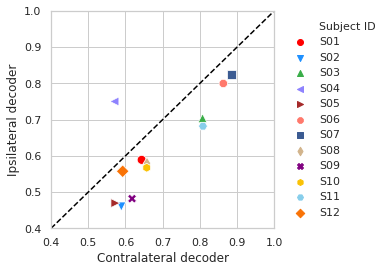

In [6]:
sns.set_style("whitegrid")
strategy = ['RandomForestClassifier', 'SVC'][0]
subset_df = report_df.query(
    'predicted_variable == "m_vs_r"').query(
    'strategy == "{}"'.format(strategy))
subset_df
plot_df = subset_df.pivot(index='patient_id', columns='side', values='test')
plot_df['subject_id'] = [ "S{:02d}".format(patient_ids.index(p_id) + 1) for p_id in plot_df.index ]
plot_df = plot_df.sort_values(by='subject_id')
# plot_df = plot_df.reset_index()
plot_df['Subject ID'] = plot_df['subject_id']

# https://github.com/mwaskom/seaborn/issues/1599
# https://matplotlib.org/2.0.2/api/markers_api.html
markers = ['o', 'v', '^', '<', 
           '>', '8', 's', 'd', 
           'X', 'h', 'H', 'D'][:len(patient_ids)]
plt.figure(figsize=(4,4))
# csfont = {'fontname':'Times New Roman'}
csfont = {}
plt.plot([0.4, 1.0], [0.4, 1.0], ls='--', c='black', )
ax = sns.scatterplot(x="C", y="I", data=plot_df, 
                     hue='Subject ID', palette=pal_name, 
                     style='Subject ID', markers=markers,
                    s=80)
plt.ylabel('Ipsilateral decoder', **csfont)
plt.xlabel('Contralateral decoder', **csfont)
plt.xlim(0.4, 1.0)
plt.ylim(0.4, 1.0)
# https://stackoverflow.com/questions/53733755/how-to-move-legend-to-outside-of-a-seaborn-scatterplot
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=False)
# ax.set_title("Test accuracy", **csfont)

## More classifier details

In [7]:
pickled_files = glob.glob(REPORT_DIR + "/*.pickle")
# pickled_files

In [8]:
# model_dict[dict_key] = [clf, return_dict]
# pickle.dump(model_dict, f_handle, pickle.HIGHEST_PROTOCOL)
models = []
return_dicts = {}
model_dicts = {}
predicted_variable = ['other_lead_overlap30', 'other_lag_overlap30', 'other_lead_lag30',][0] 
model_type = ['regress', 'classify', 'identity'][2]
for fname in pickled_files:
    if model_type in fname:
#         print(fname)
        with open(fname, 'rb') as fp:
            model_dict = pickle.load(fp)
            patient_id = fname.split('/')[-1].split('_')[0]
            if patient_id in patient_ids:
                wrist = fname.split('/')[-1].split('_')[1].lower()
                hemi = hemispheres[patient_id].lower()
                side = "I" if hemi == wrist else 'C' # Ipsi or Contra
    #             key = fname.split('/')[-1][:10] # e.g. a0f66459_r
                subject_index = patient_ids.index(patient_id) + 1
                key = "{}_S{:02d}_{}".format(side, subject_index, patient_id)
                model_dicts[key] = model_dict
    

In [9]:
# model_dicts.keys()

In [10]:
# Reports
keys = list(model_dicts.keys())
keys = sorted(keys)
classification_reports = { 
    'patient_id' : [], 
    'subject_str' : [], 
    'side' : [], 
    'hemi' : [],
    'limb' : [],
    'pr_0' : [],
    'pr_1' : [],
    'r_0' : [],
    'r_1' : [],
    'supp0' : [],
    'supp1' : [],
    'acc' : [],
    'supp0_tr' : [],
    'supp1_tr' : [],
}

for idx in range(len(keys)):
    key = keys[idx]
    patient_id = key.split('_')[-1]
    hemi = hemispheres[patient_id].lower()
    side = key.split('_')[0]
    subject_str = key.split('_')[1]
#     print(idx, patient_id, hemi, subject_str, side)

    returned = model_dicts[key]['identity_m_vs_r_RandomForestClassifier']
    if len(returned) > 4:
        clf, return_dict, feature_names,_FEATURE_MODE, X_train, X_test, y_train, y_test  = returned
    else:
        clf, return_dict, feature_names,_FEATURE_MODE  = returned

    # Common
    classification_reports['patient_id'].append( patient_id )
    classification_reports['subject_str'].append( subject_str )
    classification_reports['side'].append( side )
    classification_reports['hemi'].append( hemi )

    # Train
    cr_test  = pd.DataFrame(return_dict['classification_report_train']).T
    classification_reports['supp0_tr'].append( cr_test.loc['mv_0', 'support'] )
    limb = 'l_wrist_1' if 'l_wrist_1' in cr_test.index else 'r_wrist_1'
    classification_reports['supp1_tr'].append( cr_test.loc[limb, 'support'] )

    # Test
    cr_test  = pd.DataFrame(return_dict['classification_report_test']).T
    classification_reports['pr_0'].append( cr_test.loc['mv_0', 'precision'] )
    classification_reports['r_0'].append( cr_test.loc['mv_0', 'recall'] )
    classification_reports['supp0'].append( cr_test.loc['mv_0', 'support'] )
    classification_reports['acc'].append( cr_test.loc['accuracy', 'support'] ) # Ignore colname
    limb = 'l_wrist_1' if 'l_wrist_1' in cr_test.index else 'r_wrist_1'
    classification_reports['limb'].append( limb )
    classification_reports['pr_1'].append( cr_test.loc[limb, 'precision'] )
    classification_reports['r_1'].append( cr_test.loc[limb, 'recall'] )
    classification_reports['supp1'].append( cr_test.loc[limb, 'support'] )

classification_reports = pd.DataFrame(classification_reports).sort_values(by=['subject_str', 'side'])
for col in ['supp1', 'supp0', 'supp1_tr', 'supp0_tr', ]:
    classification_reports[col] = classification_reports[col].astype(int)
classification_reports = classification_reports.round(2)

In [11]:
# classification_reports.sort_values(by='r_1')
# classification_reports.sort_values(by='supp1')
# classification_reports.sort_values(by='acc')
classification_reports.sort_values(by=['subject_str', 'side'])
# plot_df = classification_reports.pivot(index='patient_id', columns='side', values='test')

,patient_id,subject_str,side,hemi,limb,pr_0,pr_1,r_0,r_1,supp0,supp1,acc,supp0_tr,supp1_tr
0,a0f66459,S01,C,l,r_wrist_1,0.92,0.59,0.31,0.97,108,108,0.64,263,263
12,a0f66459,S01,I,l,l_wrist_1,0.68,0.56,0.33,0.84,225,225,0.59,237,237
1,c95c1e82,S02,C,r,l_wrist_1,0.57,0.61,0.69,0.49,45,45,0.59,109,109
13,c95c1e82,S02,I,r,r_wrist_1,0.47,0.45,0.58,0.34,88,88,0.46,148,148
2,cb46fd46,S03,C,l,r_wrist_1,0.77,0.85,0.87,0.74,166,166,0.81,536,536
14,cb46fd46,S03,I,l,l_wrist_1,0.72,0.69,0.66,0.74,194,194,0.70,472,472
3,fcb01f7a,S04,C,r,l_wrist_1,0.54,0.67,0.86,0.28,64,64,0.57,147,147
15,fcb01f7a,S04,I,r,r_wrist_1,0.70,0.83,0.87,0.63,354,354,0.75,666,666
4,ffb52f92,S05,C,r,l_wrist_1,0.56,0.59,0.65,0.50,48,48,0.57,57,57
16,ffb52f92,S05,I,r,r_wrist_1,0.47,0.46,0.57,0.37,82,82,0.47,108,108


In [12]:
# Support calculations
# Conservative version
support_training = 2*pd.concat([classification_reports['supp1_tr'], classification_reports['supp0_tr']], axis=1).min(axis=1)
support_test = 2*pd.concat([classification_reports['supp1'], classification_reports['supp0']], axis=1).min(axis=1)

print("Training support mean +/- SD", support_training.mean(), support_training.std())
print("Test support mean +/- SD", support_test.mean(), support_test.std())

Training support mean +/- SD 632.9166666666666 417.45063927593174
Test support mean +/- SD 331.25 202.73848007802522


## Electrode Loadings

In [13]:
sns.set_style("white")

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, pdb
from nilearn import plotting as ni_plt
import matplotlib.pyplot as plt

from plot_utils_paper import plot_ecog_electrodes_mni_in_order
chan_labels = 'all' #use 'all' for all electrodes, or 'allgood' for goodChanInds==1

/home/satsingh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/satsingh/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/satsingh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding class

0 0 0 a0f66459 l S01 C
1 0 1 c95c1e82 r S02 C
2 0 2 cb46fd46 l S03 C
3 0 3 fcb01f7a r S04 C
4 0 4 ffb52f92 r S05 C
5 0 5 b4ac1726 l S06 C
6 0 6 f3b79359 r S07 C
7 0 7 ec761078 r S08 C
8 0 8 f0bbc9a9 l S09 C
9 0 9 abdb496b l S10 C
10 0 10 ec168864 l S11 C
11 0 11 b45e3f7b l S12 C
12 1 0 a0f66459 l S01 I
13 1 1 c95c1e82 r S02 I
14 1 2 cb46fd46 l S03 I
15 1 3 fcb01f7a r S04 I
16 1 4 ffb52f92 r S05 I
17 1 5 b4ac1726 l S06 I
18 1 6 f3b79359 r S07 I
19 1 7 ec761078 r S08 I
20 1 8 f0bbc9a9 l S09 I
21 1 9 abdb496b l S10 I
22 1 10 ec168864 l S11 I
23 1 11 b45e3f7b l S12 I


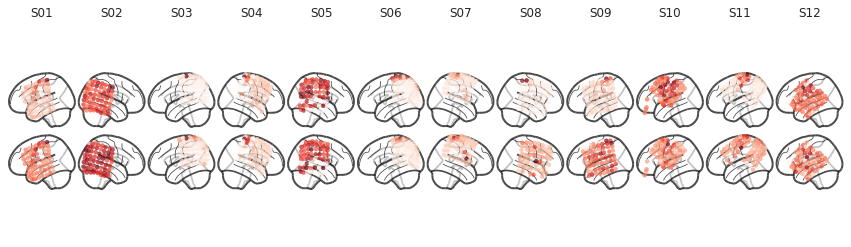

In [15]:
# Print Grid of loadings for each patient
n_rows = 2
n_cols = 12

fig, axes = plt.subplots(n_rows, n_cols, 
                         sharex=False, sharey=False, 
                         figsize=(15,4), 
                         gridspec_kw={'hspace': -0.60, 'wspace': 0.005})

keys = list(model_dicts.keys())
keys = sorted(keys)
rescaling = ['normalize', 'zscore'][0]
for idx in range(len(keys)):
    idx_x = idx // n_cols
    idx_y = idx % n_cols
    ax = axes[idx_x, idx_y]
    key = keys[idx]
    patient_id = key.split('_')[-1]
    hemi = hemispheres[patient_id].lower()
    wrist = ''
    side = key.split('_')[0]
    subject_str = key.split('_')[1]
    print(idx, idx_x, idx_y, patient_id, hemi, subject_str, side)

    returned = model_dicts[key]['identity_m_vs_r_RandomForestClassifier']
    if len(returned) > 4:
        clf, return_dict, feature_names,_FEATURE_MODE, X_train, X_test, y_train, y_test  = returned
    else:
        clf, return_dict, feature_names,_FEATURE_MODE  = returned


    topFeaturesAll = paperu.get_forest_feature_importance(clf, feature_names, viz=False)
    loadings = paperu.get_electrode_loadings(topFeaturesAll)
    
    if rescaling == 'normalize':
        def _rescale01(s): # Rescale to [0,1] 
            s = s - np.min(s) # Subtract min
            return (s/np.max(s)) # Note, not subtracting min
        loadings['Importance'] = _rescale01(loadings['Importance']) 

    if rescaling == 'zscore':
        from scipy.stats import zscore
        loadings['Importance'] = zscore(loadings['Importance']) 
    
    loadings = loadings.sort_values(by=['electrode_id'])
    data=loadings['Importance']    

    # TODO: Cleaner colors function
    palette='Reds'
    cmap = plt.cm.get_cmap(palette)
    colors=list()
    for i in range(len(data)):
        colors.append(np.asarray( cmap(data[i]) )[0:3])
    colors = np.asarray(colors)
#     print(colors)
    colors = list(map(lambda x: x[0], np.array_split(colors, colors.shape[0], axis=0)))
    color_array = colors
    
    # Plot
    elec_locs_fname = '{}/ecog_metadata/ecog_metadata_{}.csv'.format(DATA_DIR, patient_id)
    plot_ecog_electrodes_mni_in_order(
        [elec_locs_fname],
        chan_labels,
        num_grid_chans=64,
        node_size=15,
        colors_in=color_array, 
        ax_in=ax,
        elec_col_suppl_in=color_array,
        alpha=.7,
        sides_2_display=hemi,
        edge_linewidths=.5)
    if idx_x == 0: # Add Subject ID to plot
        ax.set_title(subject_str) 

In [16]:
# Print loadings for a subset of patients - clearer plots
patient_subset = [
    'a0f66459', 
#     'c95c1e82', 
    'cb46fd46', 
    'fcb01f7a', 
#     'ffb52f92', 
    'b4ac1726', 
    'f3b79359', 
    'ec761078', 
#     'f0bbc9a9', 
#     'abdb496b', 
    'ec168864', 
    'b45e3f7b'
  ]

0 0 a0f66459 l S01 C
1 0 a0f66459 l S01 I
0 1 cb46fd46 l S03 C
1 1 cb46fd46 l S03 I
0 2 fcb01f7a r S04 C
1 2 fcb01f7a r S04 I
0 3 b4ac1726 l S06 C
1 3 b4ac1726 l S06 I
0 4 f3b79359 r S07 C
1 4 f3b79359 r S07 I
0 5 ec761078 r S08 C
1 5 ec761078 r S08 I
0 6 ec168864 l S11 C
1 6 ec168864 l S11 I
0 7 b45e3f7b l S12 C
1 7 b45e3f7b l S12 I


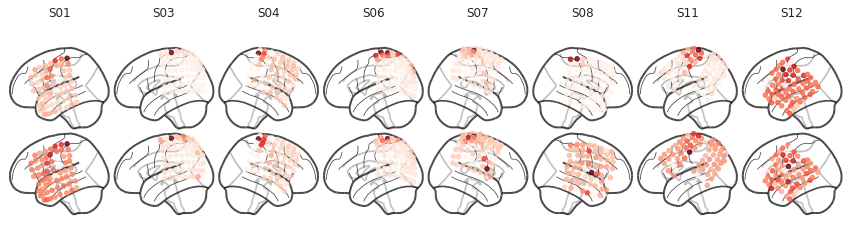

In [17]:
# Plot
n_rows = 2
n_cols = len(patient_subset)

fig, axes = plt.subplots(n_rows, n_cols, 
                         sharex=False, sharey=False, 
                         figsize=(15,4), 
                         gridspec_kw={'hspace': -0.35, 'wspace': 0.005})

keys = list(model_dicts.keys())
keys = sorted(keys)
# print(keys)
rescaling = ['normalize', 'zscore'][0]
for patient_id in patient_subset:
    for side in ['C', 'I']:
        idx_y = patient_subset.index(patient_id)
        idx_x = 1 if side == 'I' else 0
        ax = axes[idx_x, idx_y]
        hemi = hemispheres[patient_id].lower()
        subject_index = patient_ids.index(patient_id) + 1
        subject_str = "S{:02d}".format(subject_index)
        print(idx_x, idx_y, patient_id, hemi, subject_str, side)

        key = "{}_{}_{}".format(side, subject_str, patient_id)
        returned = model_dicts[key]['identity_m_vs_r_RandomForestClassifier']
        if len(returned) > 4:
            clf, return_dict, feature_names,_FEATURE_MODE, X_train, X_test, y_train, y_test  = returned
        else:
            clf, return_dict, feature_names,_FEATURE_MODE  = returned

        topFeaturesAll = paperu.get_forest_feature_importance(clf, feature_names, viz=False)
        loadings = paperu.get_electrode_loadings(topFeaturesAll)

        if rescaling == 'normalize':
            def _rescale01(s): # Rescale to [0,1] 
                s = s - np.min(s) # Subtract min
                return (s/np.max(s)) # Note, not subtracting min
            loadings['Importance'] = _rescale01(loadings['Importance']) 

        if rescaling == 'zscore':
            from scipy.stats import zscore
            loadings['Importance'] = zscore(loadings['Importance']) 

        loadings = loadings.sort_values(by=['electrode_id'])
        data=loadings['Importance']    

        # TODO: Cleaner colors function
        palette='Reds'
        cmap = plt.cm.get_cmap(palette)
        colors=list()
        for i in range(len(data)):
            colors.append(np.asarray( cmap(data[i]) )[0:3])
        colors = np.asarray(colors)
    #     print(colors)
        colors = list(map(lambda x: x[0], np.array_split(colors, colors.shape[0], axis=0)))
        color_array = colors

        # Plot
        elec_locs_fname = '{}/ecog_metadata/ecog_metadata_{}.csv'.format(DATA_DIR, patient_id)
        plot_ecog_electrodes_mni_in_order(
            [elec_locs_fname],
            chan_labels,
            num_grid_chans=64,
            node_size=20,
            colors_in=color_array, 
            ax_in=ax,
            elec_col_suppl_in=color_array,
            alpha=.8,
            sides_2_display=hemi,
            edge_linewidths=1.0)
        if idx_x == 0: # Add Subject ID to plot
            ax.set_title(subject_str) 

## Frequency Loadings

In [18]:
def get_freq_loadings(topFeaturesAll):
    # Select only electrode features (remove context etc.) and normalize 
    topFeatures = topFeaturesAll[[ 'e' == x[:1] for x in topFeaturesAll.index ]] # only electode loadings
    topFeatures['Importance'] = topFeatures['Importance']/topFeatures['Importance'].sum()

    # Aggregate loadings by electrode_id
    topFeatures['freq'] = topFeatures.index.to_series().apply(lambda x: x.split('_')[1].replace('f','') )
    topFeatures['freq'] = topFeatures['freq'].astype(float)
    loadings = topFeatures.groupby('freq').sum()
    loadings['freq'] = loadings.index
    loadings.reset_index(drop=True, inplace=True)
    loadings = loadings.sort_values(by='freq')
    return loadings

# freq_loadings = get_freq_loadings(topFeaturesAll)

In [19]:
# Frequency loadings -- Create datastructure
n_rows = 2
n_cols = 12

keys = list(model_dicts.keys())
keys = sorted(keys)
rescaling = ['normalize', 'zscore'][0]

freq_c = [] # contralateral
freq_i = [] # contralateral
for idx in range(len(keys)):
    idx_x = idx // n_cols
    idx_y = idx % n_cols
#     ax = axes[idx_x, idx_y]
    key = keys[idx]
    patient_id = key.split('_')[-1]
    hemi = hemispheres[patient_id].lower()
    wrist = ''
    side = key.split('_')[0]
    subject_str = key.split('_')[1]
    print(idx, idx_x, idx_y, patient_id, hemi, subject_str, side)

    returned = model_dicts[key]['identity_m_vs_r_RandomForestClassifier']
#     clf, return_dict, feature_names,_FEATURE_MODE, X_train, X_test, y_train, y_test  = returned
    if len(returned) > 4:
        clf, return_dict, feature_names,_FEATURE_MODE, X_train, X_test, y_train, y_test  = returned
    else:
        clf, return_dict, feature_names,_FEATURE_MODE  = returned


    topFeaturesAll = paperu.get_forest_feature_importance(clf, feature_names, viz=False)
    freq_loadings = get_freq_loadings(topFeaturesAll)
  
    f_array = np.array(freq_loadings['Importance'])
    f_array = f_array/f_array.max() # Normalize to max of 1

    if idx_x == 0:
        freq_c.append(f_array)
    else:
        freq_i.append(f_array)

0 0 0 a0f66459 l S01 C
1 0 1 c95c1e82 r S02 C
2 0 2 cb46fd46 l S03 C
3 0 3 fcb01f7a r S04 C
4 0 4 ffb52f92 r S05 C
5 0 5 b4ac1726 l S06 C
6 0 6 f3b79359 r S07 C
7 0 7 ec761078 r S08 C
8 0 8 f0bbc9a9 l S09 C
9 0 9 abdb496b l S10 C
10 0 10 ec168864 l S11 C
11 0 11 b45e3f7b l S12 C
12 1 0 a0f66459 l S01 I
13 1 1 c95c1e82 r S02 I
14 1 2 cb46fd46 l S03 I
15 1 3 fcb01f7a r S04 I
16 1 4 ffb52f92 r S05 I
17 1 5 b4ac1726 l S06 I
18 1 6 f3b79359 r S07 I
19 1 7 ec761078 r S08 I
20 1 8 f0bbc9a9 l S09 I
21 1 9 abdb496b l S10 I
22 1 10 ec168864 l S11 I
23 1 11 b45e3f7b l S12 I


In [20]:
freq_loadings.head()

,Importance,freq
0,0.039513,0.0
1,0.044509,5.2
2,0.051951,10.4
3,0.046646,15.6
4,0.037888,20.8


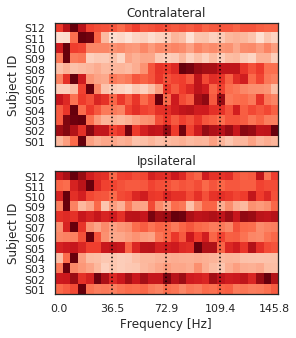

In [21]:
# Improved frequency loading plots
fig, axes = plt.subplots(2, 1, 
                         sharex=True, sharey=True, 
                         figsize=(4,5), 
                         gridspec_kw={
#                              'hspace': -0.6, 
                             'wspace': 0.05,
                         })
im1 = axes[0].imshow( np.matrix(freq_c), cmap='Reds', aspect='auto', 
                     origin='lower', vmin=0, vmax=1 )
im2 = axes[1].imshow( np.matrix(freq_i), cmap='Reds', aspect='auto', 
                     origin='lower', vmin=0, vmax=1 )

axes[0].set_title("Contralateral")
axes[1].set_title("Ipsilateral")

tick_idxs = [0, 7, 14, 21, 28]
axes[1].set_xticks(tick_idxs) # freq-idx
axes[1].set_xticklabels(freq_loadings['freq'][tick_idxs]) # freq-Hz
axes[1].set_xlabel("Frequency [Hz]")
axes[0].get_xaxis().set_visible(False)

for j in range(2):
    axes[j].set_yticks([i for i in range(12)])
    axes[j].set_yticklabels(["S{:02d}".format(i+1) for i in range(12)])
    axes[j].set_ylabel("Subject ID")
    
    for k in tick_idxs[1:-1]:
        axes[j].axvline(x=k, c='black', ls=':')